Load dataset

In [1]:
from huggingface_hub import login

login("")

c:\Ia\iosub\APDF-sparrow-donut\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\iosub\.cache\huggingface\token
Login successful


In [2]:
from datasets import load_dataset

dataset = load_dataset("katanaml-org/invoices-donut-data-v1")

Generating test split: 100%|██████████| 26/26 [00:00<00:00, 538.33 examples/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 425
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 50
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 26
    })
})

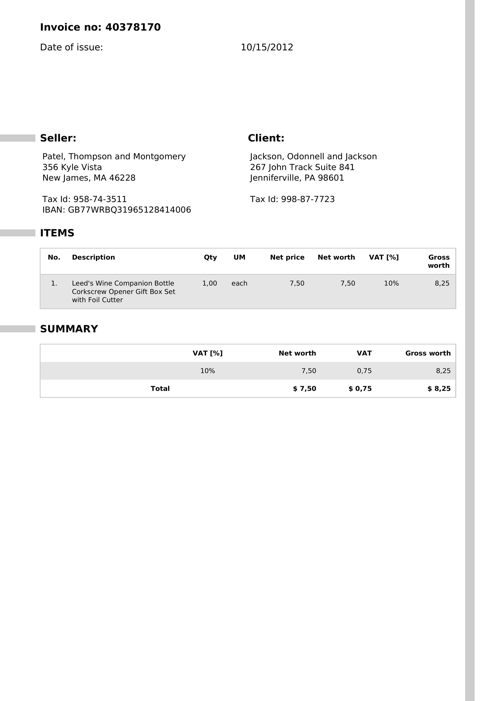

In [4]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.2), int(height*0.2))))

In [5]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"header": {"invoice_no": "40378170", "invoice_date": "10/15/2012", "seller": "Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228", "client": "Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601", "seller_tax_id": "958-74-3511", "client_tax_id": "998-87-7723", "iban": "GB77WRBQ31965128414006"}, "items": [{"item_desc": "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter", "item_qty": "1,00", "item_net_price": "7,50", "item_net_worth": "7,50", "item_vat": "10%", "item_gross_worth": "8,25"}], "summary": {"total_net_worth": "$7,50", "total_vat": "$0,75", "total_gross_worth": "$8,25"}}}


In [6]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'header': {'invoice_no': '40378170',
  'invoice_date': '10/15/2012',
  'seller': 'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228',
  'client': 'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601',
  'seller_tax_id': '958-74-3511',
  'client_tax_id': '998-87-7723',
  'iban': 'GB77WRBQ31965128414006'},
 'items': [{'item_desc': "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter",
   'item_qty': '1,00',
   'item_net_price': '7,50',
   'item_net_worth': '7,50',
   'item_vat': '10%',
   'item_gross_worth': '8,25'}],
 'summary': {'total_net_worth': '$7,50',
  'total_vat': '$0,75',
  'total_gross_worth': '$8,25'}}

Load model and processor

In [7]:
from transformers import VisionEncoderDecoderConfig

max_length = 768
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [8]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

In [11]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # inputs
        pixel_values = processor(sample["image"], random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [12]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

train_dataset = DonutDataset("katanaml-org/invoices-donut", max_length=max_length,
                             split="train", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

val_dataset = DonutDataset("katanaml-org/invoices-donut", max_length=max_length,
                             split="validation", task_start_token="<s_cord-v2>", prompt_end_token="<s_cord-v2>",
                             sort_json_key=False, # cord dataset is preprocessed, so no need for this
                             )

c:\Ia\iosub\APDF-sparrow-donut\.venv\Lib\site-packages\transformers\models\donut\processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Generating test split: 100%|██████████| 26/26 [00:00<00:00, 1077.78 examples/s]


In [13]:
len(added_tokens)

42

In [14]:
len(processor.tokenizer)

57566

In [15]:
processor.tokenizer.vocab_size

57522

In [16]:
pixel_values, labels, target_sequence = train_dataset[0]

In [17]:
print(pixel_values.shape)

torch.Size([3, 1280, 960])


In [18]:
for id in labels.tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_header>
<s_invoice_no>
40
3
78
170
</s_invoice_no>
<s_invoice_date>
10
/15
/
2012
</s_invoice_date>
<s_seller>
Pa
tel
,
Thompson
and
Mont
gom
ery
3
56
Kyl
e
Vista
New
James
,


In [19]:
print(target_sequence)

<s_header><s_invoice_no>40378170</s_invoice_no><s_invoice_date>10/15/2012</s_invoice_date><s_seller>Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228</s_seller><s_client>Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</s_client><s_seller_tax_id>958-74-3511</s_seller_tax_id><s_client_tax_id>998-87-7723</s_client_tax_id><s_iban>GB77WRBQ31965128414006</s_iban></s_header><s_items><s_item_desc>Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</s_item_desc><s_item_qty>1,00</s_item_qty><s_item_net_price>7,50</s_item_net_price><s_item_net_worth>7,50</s_item_net_worth><s_item_vat>10%</s_item_vat><s_item_gross_worth>8,25</s_item_gross_worth></s_items><s_summary><s_total_net_worth>$7,50</s_total_net_worth><s_total_vat>$0,75</s_total_vat><s_total_gross_worth>$8,25</s_total_gross_worth></s_summary></s>


In [20]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_cord-v2>'])[0]

In [21]:
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_cord-v2>


Create PyTorch DataLoaders

In [23]:
from torch.utils.data import DataLoader

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
# Set num_workers=4
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

In [ ]:
for id in labels.squeeze().tolist()[:30]:
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

In [ ]:
batch = next(iter(val_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

In [ ]:
print(target_sequences[0])

Define LightingModule

In [ ]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)

        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            # NOT NEEDED ANYMORE
            # answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        cnt = [0] * num_of_loaders
        total_metric = [0] * num_of_loaders
        val_metric = [0] * num_of_loaders
        for i, results in enumerate(validation_step_outputs):
            for scores in results:
                cnt[i] += len(scores)
                total_metric[i] += np.sum(scores)
            val_metric[i] = total_metric[i] / cnt[i]
            val_metric_name = f"val_metric_{i}th_dataset"
            self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # TODO add scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

Train

In [ ]:
# Set epochs = 30
# Set num_training_samples_per_epoch = training set size
config = {"max_epochs":30,
          "val_check_interval":0.4, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 425,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 81, # 425 / 8 = 54, 54 * 10 = 540, 540 * 0.15 = 81
          "result_path": "./result",
          "verbose": False,
          }

model_module = DonutModelPLModule(config, processor, model)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback

wandb_logger = WandbLogger(project="Sparrow", name="invoices-donut-v5")

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub("katanaml-org/invoices-donut-model-v1",
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub("katanaml-org/invoices-donut-model-v1",
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub("katanaml-org/invoices-donut-model-v1",
                                    commit_message=f"Training done")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0,
        logger=wandb_logger,
        callbacks=[PushToHubCallback()],
)

trainer.fit(model_module)

Evaluation

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("katanaml-org/invoices-donut-model-v1")
model = VisionEncoderDecoderModel.from_pretrained("katanaml-org/invoices-donut-model-v1")

In [ ]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np

from donut import JSONParseEvaluator

from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

dataset = load_dataset("katanaml-org/invoices-donut", split="test")

for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    ground_truth = ground_truth["gt_parse"]
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

In [ ]:
print("Mean accuracy:", np.mean(accs))